# Serial subset obserations

In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time
from scipy import linalg as la
from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl, f_l2_Hankel_comp_Q_Om
from ssidid.utility import get_subpop_stats, gen_data
from ssidid import ObservationScheme
from subtracking import Grouse, calc_subspace_proj_error
from ssidid.icml_scripts import run_default

run = '_e3'
# define problem size
lag_range = np.arange(30)
kl_ = np.max(lag_range)+1
p, n = 1000, 10
T_full = 100000 + kl_
T = T_full

nr = 0 # number of real eigenvalues
snr = (1., 1.)
whiten = True
eig_m_r, eig_M_r, eig_m_c, eig_M_c = 0.90, 0.99, 0.90, 0.99

def principal_angle(A, B):
    "A and B must be column-orthogonal."    
    A = np.atleast_2d(A).T if (A.ndim<2) else A
    B = np.atleast_2d(B).T if (B.ndim<2) else B
    A = la.orth(A)
    B = la.orth(B)
    svd = la.svd(A.T.dot(B))
    return np.arccos(np.minimum(svd[1], 1.0)) / (np.pi/2)


# I/O matter
mmap, chunksize = True, np.min((p,1000))
verbose=True

rnd_seeds = range(34,35)
overlaps = (15,20,25,1000)


for rnd_seed in rnd_seeds:
    
    data_path =  '/home/mackelab/Desktop/Projects/Stitching/results/icml_e3/seed_' + str(rnd_seed) + '/'

    print('\n')
    print('\n')
    print('seed:', str(rnd_seed))
    print('\n')
    print('\n')
    
    y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))
        
    idx_a, idx_b = np.arange(p), np.arange(p)

    file_name = 'p'+str(p)+'n'+str(n)+'T'+str(T_full)+str(run)+'_init'
    load_file = np.load(data_path + file_name + '.npz')['arr_0'].tolist()    
    pars_true = load_file['pars_true']
    print('angles ev(A): ', np.sort(np.angle(np.linalg.eigvals(pars_true['A'])))/np.pi)
    
    """
    np.random.seed(rnd_seed)
    pars_true, x, y, _, _ = gen_data(p,n,lag_range,T_full, nr,
                                     eig_m_r, eig_M_r, 
                                     eig_m_c, eig_M_c,
                                     mmap, chunksize,
                                     data_path,
                                     snr=snr, whiten=whiten)        

    pars_true['X'] = np.vstack([ np.linalg.matrix_power(pars_true['A'],m).dot(pars_true['Pi']) for m in lag_range])
    """
    
    idx_a, idx_b = np.arange(p), np.arange(p)

    sso = True

    for overlap in overlaps:

        # compute length of recordings to keep total observation count stable    
        print('(p,n,k+l,T) = ', (p,n,len(lag_range),T), '\n')

        sub_pops = (np.arange((p+overlap)//2),np.arange((p-overlap)//2,p))

        reps = 1
        obs_pops = np.concatenate([ np.arange(len(sub_pops)) for r in range(reps) ])
        obs_time = np.linspace(0,T, len(obs_pops)+1)[1:].astype(int)
        obs_scheme = ObservationScheme(p=p, T=T, 
                                        sub_pops=sub_pops, 
                                        obs_pops=obs_pops, 
                                        obs_time=obs_time)

        
        W = obs_scheme.comp_coocurrence_weights(lag_range, sso=sso, idx_a=idx_a, idx_b=idx_b)
        if overlap < p:
            for m in range(len(lag_range)):
                W[m][0,1] = 0
                W[m][1,0] = 0

        print('computing time-lagged covariances')
        Qs, Om = f_l2_Hankel_comp_Q_Om(n=n,y=y,lag_range=lag_range,obs_scheme=obs_scheme,
                              idx_a=idx_a,idx_b=idx_b,W=W,sso=sso,
                              mmap=mmap,data_path=data_path,ts=None,ms=None)    
        if overlap < p:
            for m in range(len(lag_range)):    
                Om[m][np.ix_(obs_scheme.idx_grp[0], obs_scheme.idx_grp[1])] = False
                Om[m][np.ix_(obs_scheme.idx_grp[1], obs_scheme.idx_grp[0])] = False

        print_slim(Qs,Om,lag_range,pars_true,idx_a,idx_b,None,False,data_path)
        print('true param. loss: ', f_l2_Hankel_nl(C=pars_true['C'],X=pars_true['X'],R=pars_true['R'],
                                       Qs=Qs,Om=Om,lag_range=lag_range,ms=range(len(lag_range)),idx_a=idx_a,idx_b=idx_b))        

        
        """
        
        file_name = 'p'+str(p)+'n'+str(n)+'T'+str(T)+str(run)+'_'+str(overlap)
        load_file = np.load(data_path + file_name + '.npz')['arr_0'].tolist()            
        pars_est = load_file['pars_est']
        traces = load_file['traces']
        ts = load_file['ts']
        W,Qs,Om =  load_file['W'],load_file['Qs'],load_file['Om']
        obs_scheme = load_file['obs_scheme']
        
        print_slim(Qs,Om,lag_range,pars_true,idx_a,idx_b,None,False,data_path)
        print('true param. loss: ', f_l2_Hankel_nl(C=pars_true['C'],X=pars_true['X'],R=pars_true['R'],
                                       Qs=Qs,Om=Om,lag_range=lag_range,ms=range(len(lag_range)),idx_a=idx_a,idx_b=idx_b))        

                                                   
        print_slim(Qs,Om,lag_range,pars_est,idx_a,idx_b,traces[-1],False,data_path)
        print('est. param. loss: ', f_l2_Hankel_nl(C=pars_est['C'],X=pars_est['X'],R=pars_est['R'],
                                       Qs=Qs,Om=Om,lag_range=lag_range,ms=range(len(lag_range)),idx_a=idx_a,idx_b=idx_b))        
                
        """
        
        sub_pops = obs_scheme.sub_pops
        print('\n')
        if len(sub_pops) > 1:
            print('overlap: ', str(len(np.intersect1d(sub_pops[0], sub_pops[1]))))    
        print('\n')
        print('sp. #1: ', obs_scheme.sub_pops[0])
        print('sp. #2: ', obs_scheme.sub_pops[1]) 
        
        pars_est, traces, ts= run_default(
                    alphas    = (0.01, 0.005, 0.001, 0.0001), 
                    b1s       = (0.98, 0.95,  0.95,  0.9), 
                    a_decays  = (0.98, 0.98,  0.99,  0.99), 
                    batch_sizes = (1, 10,    10,    50), 
                    max_zip_sizes =  (1000,100,100, 5), 
                    max_iters = (150, 250, 250, 100),
                    parametrizations = ('nl', 'nl', 'ln', 'ln'),
                    pars_est='default', pars_true=pars_true, n=n, 
                    y=y, sso=sso, obs_scheme=obs_scheme, lag_range=lag_range, 
                    idx_a=idx_a, idx_b=idx_b,Qs=Qs,Om=Om, W=W,
                    traces=[[], [], []], ts = [])    


        print('per-subpops principal angles')
        C = pars_est['C'].copy()
        print(principal_angle(pars_true['C'][sub_pops[0],:], C[sub_pops[0],:]))
        print(principal_angle(pars_true['C'][sub_pops[1],:], C[sub_pops[1],:]))

        print('final principal angles')
        C = pars_est['C'].copy()
        print(principal_angle(pars_true['C'], C))

        print('final principal angles (sign-flipped)')
        C = pars_est['C'].copy()
        C[sub_pops[0],:] *= -1
        print(principal_angle(pars_true['C'], C))

        del C

        # settings for GROUSE
        a_grouse = 1
        tracker = Grouse(p, n, a_grouse )
        max_epoch_size = 1000
        max_iter_grouse = 1000
        get_obs = obs_scheme.gen_get_observed()

        # fit GROUSE
        print('\n - GROUSE')
        tracker.step = a_grouse
        ct = 1.
        error = np.zeros((max_iter_grouse, n+1))
        t = time.time()
        get_obs = obs_scheme.gen_get_observed()
        for i in range(max_iter_grouse):
            if np.mod(i,max_iter_grouse//10) == 0:
                print('finished % ' + str((100*i)//max_iter_grouse))
            idx = np.random.permutation(T-np.max(lag_range)-1)
            idx = idx[:max_epoch_size] if len(idx) > max_epoch_size else idx
            for j in range(len(idx)):
                obs_idx =  np.zeros((p,1), dtype=bool)
                obs_idx[get_obs(idx[j])] = True
                tracker.consume(y[idx[j],:].reshape(-1,1), obs_idx)
                ct += 1     
                tracker.step = a_grouse / ct

            error[i] = np.hstack((calc_subspace_proj_error(pars_true['C'], tracker.U), principal_angle(pars_true['C'], tracker.U)))
        t = time.time() - t

        pars_est_g = {'C' : tracker.U.copy()}
        traces_g = [error.copy()]
        ts_g = [t]

        save_dict = {'p' : p,'n' : n,'T' : T,'snr' : snr,'lag_range' : lag_range,
                     'obs_scheme' : obs_scheme, 'mmap' : mmap,'y' : data_path if mmap else y,
                     'pars_true' : pars_true, 'pars_est' : pars_est, 'pars_est_g' : pars_est_g,
                     'idx_a' : idx_a,'idx_b' : idx_b, 'W' : W,'Qs' : Qs,'Om' : Om,
                     'traces' : traces, 'traces_g' : traces_g, 'ts':ts, 'ts_g':ts_g,
                     'rnd_seed' : rnd_seed
                    }
        file_name = 'p'+str(p)+'n'+str(n)+'T'+str(T)+str(run)+'_'+str(overlap)
        np.savez(data_path + file_name, save_dict)    

        print('final proj. error (est.): ', str(error[-1][0]))

        plt.subplot(1,2,1)
        plt.plot(error[:,1:])
        plt.title('subspace proj. error (GROUSE)')
        plt.subplot(1,2,2)
        plt.loglog(error[:,1:])
        plt.title('subspace proj. error (GROUSE)')
        plt.show()

        print('per-subpops principal angles')
        C = pars_est_g['C'].copy()
        print(principal_angle(pars_true['C'][sub_pops[0],:], C[sub_pops[0],:]))
        print(principal_angle(pars_true['C'][sub_pops[1],:], C[sub_pops[1],:]))

        print('final principal angles')
        C = pars_est_g['C'].copy()
        print(principal_angle(pars_true['C'], C))

        print('final principal angles (sign-flipped)')
        C = pars_est_g['C'].copy()
        C[sub_pops[0],:] *= -1
        print(principal_angle(pars_true['C'], C))

        del C    


In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time
from scipy import linalg as la
from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl, f_l2_Hankel_comp_Q_Om
from ssidid.utility import get_subpop_stats, gen_data
from ssidid import ObservationScheme
from subtracking import Grouse, calc_subspace_proj_error
from ssidid.icml_scripts import run_default

run = '_e3'
# define problem size
lag_range = np.arange(30)
kl_ = np.max(lag_range)+1
p, n = 1000, 10
T_full = 100000 + kl_
T = T_full

nr = 0 # number of real eigenvalues
snr = (1., 1.)
whiten = True
eig_m_r, eig_M_r, eig_m_c, eig_M_c = 0.90, 0.99, 0.90, 0.99

def principal_angle(A, B):
    "A and B must be column-orthogonal."    
    A = np.atleast_2d(A).T if (A.ndim<2) else A
    B = np.atleast_2d(B).T if (B.ndim<2) else B
    A = la.orth(A)
    B = la.orth(B)
    svd = la.svd(A.T.dot(B))
    return np.arccos(np.minimum(svd[1], 1.0)) / (np.pi/2)


# I/O matter
mmap, chunksize = True, np.min((p,1000))
verbose=True

rnd_seeds = range(30,40)

for rnd_seed in rnd_seeds:
    data_path =  '/home/mackelab/Desktop/Projects/Stitching/results/icml_e3/seed_' + str(rnd_seed) + '/'

    print('\n')
    print('\n')
    print('seed:', str(rnd_seed))
    print('\n')
    print('\n')
    
    y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))
        
    idx_a, idx_b = np.arange(p), np.arange(p)

    file_name = 'p'+str(p)+'n'+str(n)+'T'+str(T_full)+str(run)+'_init'
    load_file = np.load(data_path + file_name + '.npz')['arr_0'].tolist()    
    pars_true = load_file['pars_true']
    print('angles ev(A): ', np.sort(np.angle(np.linalg.eigvals(pars_true['A'])))/np.pi)
    
    sso = True

    overlaps = (0,)

    for overlap in overlaps:

        # compute length of recordings to keep total observation count stable    
        print('(p,n,k+l,T) = ', (p,n,len(lag_range),T), '\n')

        sub_pops = (np.arange((p+overlap)//2),np.arange((p-overlap)//2,p))

        reps = 1
        obs_pops = np.concatenate([ np.arange(len(sub_pops)) for r in range(reps) ])
        obs_time = np.linspace(0,T, len(obs_pops)+1)[1:].astype(int)
        obs_scheme = ObservationScheme(p=p, T=T, 
                                        sub_pops=sub_pops, 
                                        obs_pops=obs_pops, 
                                        obs_time=obs_time)
        print('\n')
        if len(sub_pops) > 1:
            print('overlap: ', str(len(np.intersect1d(sub_pops[0], sub_pops[1]))))    
        print('\n')
        print('sp. #1: ', obs_scheme.sub_pops[0])
        print('sp. #2: ', obs_scheme.sub_pops[1]) 

        """
        pars_est, traces, ts= run_default(
                    alphas    = (0.01, 0.005, 0.001, 0.0001), 
                    b1s       = (0.98, 0.95,  0.95,  0.9), 
                    a_decays  = (0.98, 0.98,  0.99,  0.99), 
                    batch_sizes = (1, 10,    10,    50), 
                    max_zip_sizes =  (1000,100,100, 5), 
                    max_iters = (150, 250, 250, 100),
                    parametrizations = ('nl', 'nl', 'ln', 'ln'),
                    pars_est='default', pars_true=pars_true, n=n, 
                    y=y, sso=sso, obs_scheme=obs_scheme, lag_range=lag_range, 
                    idx_a=idx_a, idx_b=idx_b,Qs=Qs,Om=Om, W=W,
                    traces=[[], [], []], ts = [])    
        """
        
        file_name = 'p'+str(p)+'n'+str(n)+'T'+str(T)+str(run)+'_'+str(overlap)
        load_file = np.load(data_path + file_name + '.npz')['arr_0'].tolist()            
        pars_est = load_file['pars_est']
        traces = load_file['traces']
        ts = load_file['ts']
        W,Qs,Om =  load_file['W'],load_file['Qs'],load_file['Om']
        obs_scheme = load_file['obs_scheme']
        
        print_slim(Qs,Om,lag_range,pars_true,idx_a,idx_b,None,False,data_path)
        print('true param. loss: ', f_l2_Hankel_nl(C=pars_true['C'],X=pars_true['X'],R=pars_true['R'],
                                       Qs=Qs,Om=Om,lag_range=lag_range,ms=range(len(lag_range)),idx_a=idx_a,idx_b=idx_b))        

                                                   
        print_slim(Qs,Om,lag_range,pars_est,idx_a,idx_b,traces[-1],False,data_path)
        print('est. param. loss: ', f_l2_Hankel_nl(C=pars_est['C'],X=pars_est['X'],R=pars_est['R'],
                                       Qs=Qs,Om=Om,lag_range=lag_range,ms=range(len(lag_range)),idx_a=idx_a,idx_b=idx_b))        
                                                   
        pars_est, traces, ts= run_default(
                    alphas    = (0.005, 0.001, 0.0001), 
                    b1s       = (0.95,  0.95,  0.9), 
                    a_decays  = (0.98,  0.99,  0.99), 
                    batch_sizes = (10,    10,    50), 
                    max_zip_sizes =  (100,100, 5), 
                    max_iters = (250, 250, 100),
                    parametrizations = ('nl', 'ln', 'ln'),
                    pars_est=pars_est, pars_true=pars_true, n=n, 
                    y=y, sso=sso, obs_scheme=obs_scheme, lag_range=lag_range, 
                    idx_a=idx_a, idx_b=idx_b,Qs=Qs,Om=Om, W=W,
                    traces=traces, ts = ts)    
        

        print('per-subpops principal angles')
        C = pars_est['C'].copy()
        print(principal_angle(pars_true['C'][sub_pops[0],:], C[sub_pops[0],:]))
        print(principal_angle(pars_true['C'][sub_pops[1],:], C[sub_pops[1],:]))

        print('final principal angles')
        C = pars_est['C'].copy()
        print(principal_angle(pars_true['C'], C))

        print('final principal angles (sign-flipped)')
        C = pars_est['C'].copy()
        C[sub_pops[0],:] *= -1
        print(principal_angle(pars_true['C'], C))

        del C

        # settings for GROUSE
        a_grouse = 1
        tracker = Grouse(p, n, a_grouse )
        max_epoch_size = 100
        max_iter_grouse = 100
        get_obs = obs_scheme.gen_get_observed()

        # fit GROUSE
        print('\n - GROUSE')
        tracker.step = a_grouse
        ct = 1.
        error = np.zeros((max_iter_grouse, n+1))
        t = time.time()
        get_obs = obs_scheme.gen_get_observed()
        for i in range(max_iter_grouse):
            if np.mod(i,max_iter_grouse//10) == 0:
                print('finished % ' + str((100*i)//max_iter_grouse))
            idx = np.random.permutation(T-np.max(lag_range)-1)
            idx = idx[:max_epoch_size] if len(idx) > max_epoch_size else idx
            for j in range(len(idx)):
                obs_idx =  np.zeros((p,1), dtype=bool)
                obs_idx[get_obs(idx[j])] = True
                tracker.consume(y[idx[j],:].reshape(-1,1), obs_idx)
                ct += 1     
                tracker.step = a_grouse / ct

            error[i] = np.hstack((calc_subspace_proj_error(pars_true['C'], tracker.U), principal_angle(pars_true['C'], tracker.U)))
        t = time.time() - t

        pars_est_g = {'C' : tracker.U.copy()}
        traces_g = [error.copy()]
        ts_g = [t]

        save_dict = {'p' : p,'n' : n,'T' : T,'snr' : snr,'lag_range' : lag_range,
                     'obs_scheme' : obs_scheme, 'mmap' : mmap,'y' : data_path if mmap else y,
                     'pars_true' : pars_true, 'pars_est' : pars_est, 'pars_est_g' : pars_est_g,
                     'idx_a' : idx_a,'idx_b' : idx_b, 'W' : W,'Qs' : Qs,'Om' : Om,
                     'traces' : traces, 'traces_g' : traces_g, 'ts':ts, 'ts_g':ts_g,
                     'rnd_seed' : rnd_seed
                    }
        file_name = 'p'+str(p)+'n'+str(n)+'T'+str(T)+str(run)+'_'+str(overlap)
        np.savez(data_path + file_name, save_dict)    

        print('final proj. error (est.): ', str(error[-1][0]))

        plt.subplot(1,2,1)
        plt.plot(error[:,1:])
        plt.title('subspace proj. error (GROUSE)')
        plt.subplot(1,2,2)
        plt.loglog(error[:,1:])
        plt.title('subspace proj. error (GROUSE)')
        plt.show()

        print('per-subpops principal angles')
        C = pars_est_g['C'].copy()
        print(principal_angle(pars_true['C'][sub_pops[0],:], C[sub_pops[0],:]))
        print(principal_angle(pars_true['C'][sub_pops[1],:], C[sub_pops[1],:]))

        print('final principal angles')
        C = pars_est_g['C'].copy()
        print(principal_angle(pars_true['C'], C))

        print('final principal angles (sign-flipped)')
        C = pars_est_g['C'].copy()
        C[sub_pops[0],:] *= -1
        print(principal_angle(pars_true['C'], C))

        del C    



In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time
from scipy import linalg as la
from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl, f_l2_Hankel_comp_Q_Om
from ssidid.utility import get_subpop_stats, gen_data
from ssidid import ObservationScheme
from subtracking import Grouse, calc_subspace_proj_error
from ssidid.icml_scripts import run_default

data_path =  '/home/mackelab/Desktop/Projects/Stitching/results/icml_e3/'

p,n,T,run = 1000,20, 200020, '_e3'
file_name = 'p'+str(p)+'n'+str(n)+'T'+str(T)+str(run)+'_init'
load_file = np.load(data_path + file_name + '.npz')['arr_0'].tolist()
lag_range=load_file['lag_range']
mmap, y, pars_true, rnd_seed = load_file['mmap'],load_file['y'],load_file['pars_true'],load_file['rnd_seed']
idx_a, idx_b = np.arange(p), np.arange(p)
snr = load_file['snr']

y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))

def principal_angle(A, B):
    "A and B must be column-orthogonal."    
    A = np.atleast_2d(A).T if (A.ndim<2) else A
    B = np.atleast_2d(B).T if (B.ndim<2) else B
    A = la.orth(A)
    B = la.orth(B)
    svd = la.svd(A.T.dot(B))
    return np.arccos(np.minimum(svd[1], 1.0)) / (np.pi/2)

# Get estimates of linear latent dynamics

In [ ]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import linalg as la
import glob, os, psutil, time

from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl, f_l2_Hankel_comp_Q_Om
from ssidid import ObservationScheme, progprint_xrange
from subtracking import Grouse, calc_subspace_proj_error







rnd_seed = 32







data_path =  '/home/mackelab/Desktop/Projects/Stitching/results/icml_e3/seed_' + str(rnd_seed) + '/'
mmap, verbose = True, True

run = '_e3_init'
p,T_full,n,snr,lag_range = 1000, 200020, 20, (1., 1.), np.arange(20)
file_name = 'p' + str(p) + 'n' + str(n) + 'T' + str(T_full) +  run
load_file = np.load(data_path + file_name + '.npz')['arr_0'].tolist()
pars_true = load_file['pars_true'].copy()
del file_name
kl_ = np.max(lag_range)+1
ev_true = np.linalg.eigvals(pars_true['A'])

def principal_angle(A, B):
    "A and B must be column-orthogonal."    
    A = np.atleast_2d(A).T if (A.ndim<2) else A
    B = np.atleast_2d(B).T if (B.ndim<2) else B
    A = la.orth(A)
    B = la.orth(B)
    svd = la.svd(A.T.dot(B))
    return np.arccos(np.minimum(svd[1], 1.0)) / (np.pi/2)


overlaps = (0,1,10,15,20,25,50,100,300,500,700,900,1000)
run = '_e3'
for i in range(len(overlaps)):
    
    T = T_full
    overlap = overlaps[i]
    
    print('T = ', T)
    print('overlap =', overlap)
    y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))

    
    file_name = 'p'+str(p)+'n'+str(n)+'T'+str(T)+'_e3_' + str(overlap)
    load_file = np.load(data_path + file_name + '.npz')['arr_0'].tolist()
    obs_scheme, W,Qs,Om = load_file['obs_scheme'], load_file['W'],load_file['Qs'],load_file['Om']
    pars_est_g = load_file['pars_est_g']
    traces_g = load_file['traces_g']
    idx_a, idx_b = load_file['idx_a'].copy(), load_file['idx_b'].copy()

    print('filtering data') 
    obs_scheme.gen_mask_from_scheme()
    tracker = Grouse(p, n, 0. )
    tracker.U = pars_est_g['C'].copy()
    x_g = np.zeros((T,n))
    for t in range (T):
        x_g[t,:] = tracker._project(y[t,:].reshape(p,1), obs_scheme.mask[t,:].reshape(p,1)).reshape(-1)
    obs_scheme.mask = None

    print('extracting dynamics parameters') 
    pars_est_g['X'] = np.vstack([np.cov(x_g[m:-(kl_+1)+m, :].T, x_g[:-(kl_+1), :].T)[:n,n:] for m in lag_range])
    pars_est_g['A'] = np.linalg.lstsq(pars_est_g['X'][:(len(lag_range)-1)*n,:], pars_est_g['X'][n:len(lag_range)*n,:])[0]
    pars_est_g['Pi'] = (pars_est_g['X'][:n,:] + pars_est_g['X'][:n,:].T)/2 
    ev_est = np.linalg.eigvals(pars_est_g['A'])

    print('storing')
    save_dict = {'p' : p,'n' : n,'T' : T,'snr' : snr,'lag_range' : lag_range,
                 'obs_scheme' : obs_scheme, 'mmap' : mmap,'y' : data_path if mmap else y,
                 'pars_true' : load_file['pars_true'], 'pars_est' : load_file['pars_est'], 
                 'idx_a' : load_file['idx_a'],'idx_b' : load_file['idx_b'], 'W' : W,'Qs' : Qs,'Om' : Om,
                 'traces' : load_file['traces'], 'ts': load_file['ts'], 
                 'rnd_seed' : load_file['rnd_seed'], 
                 'pars_est_g' : pars_est_g, 'traces_g' :  load_file['traces_g'], 'ts_g': load_file['ts_g']
                }
    file_name = 'p'+str(p)+'n'+str(n)+'T'+str(T)+str(run)+'_'+str(overlap)
    np.savez(data_path + file_name, save_dict)        


# missing at random





seed: 30




(p,n,k+l,T) =  (20, 10, 20, 520) 



/home/mackelab/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:86: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


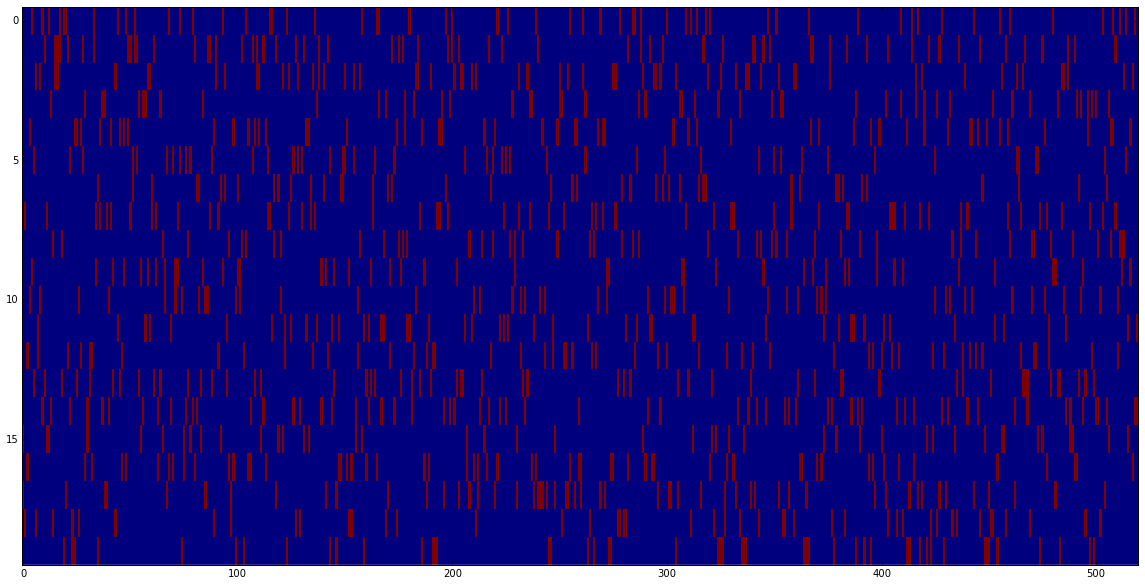

computing time-lagged covariances
true param. loss:  1655.47901851
m = 0, corr = 0.805742243092
m = 1, corr = 0.350177870445
m = 2, corr = 0.417122621993
m = 3, corr = 0.340440969206
m = 4, corr = 0.311817857765
m = 5, corr = 0.330880334995
m = 6, corr = 0.32025184634
m = 7, corr = 0.339517209265
m = 8, corr = 0.227223376135
m = 9, corr = 0.350559623941
m = 10, corr = 0.276990374712
m = 11, corr = 0.242406654373
m = 12, corr = 0.369928610323
m = 13, corr = 0.186801546275
m = 14, corr = 0.224534363859
m = 15, corr = 0.183767170276
m = 16, corr = 0.184315219346
m = 17, corr = 0.195284708573
m = 18, corr = 0.0903673076042
m = 19, corr = 0.156085581255
parametrization: nl
starting descent
finished % 10.0
f =  2755.35716134
finished % 20.0
f =  1839.90372385
finished % 30.0
f =  1804.97639561
finished % 40.0
f =  1749.92406717
finished % 50.0
f =  1704.391951
finished % 60.0
f =  1638.50631915
finished % 70.0
f =  1616.67812551
finished % 80.0
f =  1599.12238988
finished % 90.0
f =  1585.76

/home/mackelab/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:2151: RuntimeWarning: invalid value encountered in true_divide
  return c / sqrt(multiply.outer(d, d))


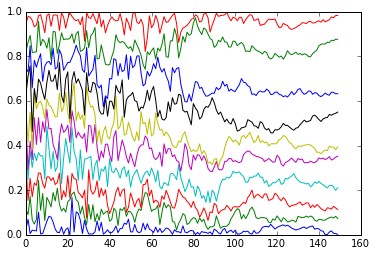

parametrization: nl
starting descent
finished % 10.0
f =  1575.48305135
finished % 20.0
f =  1558.87606008
finished % 30.0
f =  1545.91572039
finished % 40.0
f =  1534.82341698
finished % 50.0
f =  1529.03489596
finished % 60.0
f =  1529.22487402
finished % 70.0
f =  1526.45860361
finished % 80.0
f =  1525.13179108
finished % 90.0
f =  1524.82782939
finished % 100.0
f =  1523.5561264
total iterations:  12500
m = 0, corr = 0.597906392297
m = 1, corr = 0.530497223086
m = 2, corr = 0.530083259633
m = 3, corr = 0.53973402318
m = 4, corr = 0.554601336036
m = 5, corr = 0.492365504395
m = 6, corr = 0.446615094249
m = 7, corr = 0.470741612756
m = 8, corr = 0.55169924919
m = 9, corr = 0.557810949338
m = 10, corr = 0.597558775941
m = 11, corr = 0.589736520414
m = 12, corr = 0.499707972905
m = 13, corr = 0.436419472743
m = 14, corr = 0.519825879943
m = 15, corr = 0.46472692469
m = 16, corr = 0.5086472511
m = 17, corr = 0.554024534305
m = 18, corr = 0.421824468822
m = 19, corr = 0.447361540134
fit

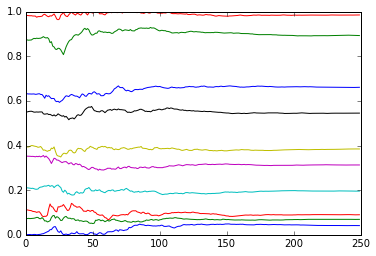

parametrization: ln
starting descent
finished % 10.0
f =  1696.24570591
finished % 20.0
f =  1677.17356018
finished % 30.0
f =  1657.06698831
finished % 40.0
f =  1660.60939234
finished % 50.0
f =  1661.43515851
finished % 60.0
f =  1655.39849435
finished % 70.0
f =  1657.65254891
finished % 80.0
f =  1651.46193584
finished % 90.0
f =  1648.74446803
finished % 100.0
f =  1654.59322549
total iterations:  12500
m = 0, corr = 0.582841644774
m = 1, corr = 0.512295422791
m = 2, corr = 0.378461601154
m = 3, corr = 0.274315195172
m = 4, corr = 0.274587135589
m = 5, corr = 0.288289128844
m = 6, corr = 0.32375519824
m = 7, corr = 0.197847541334
m = 8, corr = 0.219986809077
m = 9, corr = 0.2222494706
m = 10, corr = 0.314488941295
m = 11, corr = 0.258136119534
m = 12, corr = 0.255105661307
m = 13, corr = 0.267225508433
m = 14, corr = 0.24357091666
m = 15, corr = 0.169772323158
m = 16, corr = 0.205746389383
m = 17, corr = 0.181108533444
m = 18, corr = 0.133906002357
m = 19, corr = 0.282230939215
f

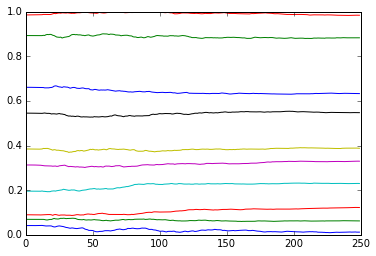

parametrization: ln
starting descent
finished % 10.0
f =  1652.79279801
finished % 20.0
f =  1652.7801964
finished % 30.0
f =  1652.76247984
finished % 40.0
f =  1652.72657321
finished % 50.0
f =  1652.68909773
finished % 60.0
f =  1652.6131227
finished % 70.0
f =  1652.61932134
finished % 80.0
f =  1652.51345855
finished % 90.0
f =  1652.47255192
finished % 100.0
f =  1652.26246688
total iterations:  1000
m = 0, corr = 0.583124555992
m = 1, corr = 0.513168075664
m = 2, corr = 0.378881176109
m = 3, corr = 0.275580986433
m = 4, corr = 0.276431333841
m = 5, corr = 0.291334139255
m = 6, corr = 0.327272426364
m = 7, corr = 0.202463153425
m = 8, corr = 0.223036290434
m = 9, corr = 0.224859536665
m = 10, corr = 0.315941791482
m = 11, corr = 0.259879974741
m = 12, corr = 0.258443583104
m = 13, corr = 0.269040973358
m = 14, corr = 0.245577287886
m = 15, corr = 0.171224932453
m = 16, corr = 0.20721989501
m = 17, corr = 0.183967434007
m = 18, corr = 0.136759042238
m = 19, corr = 0.284126793089
f

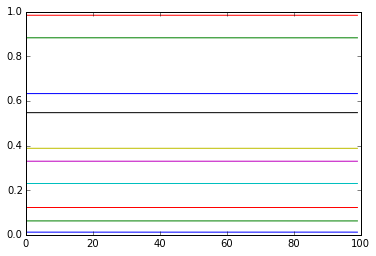


 - GROUSE
finished % 0
finished % 10
finished % 20
finished % 30
finished % 40
finished % 50
finished % 60
finished % 70
finished % 80
finished % 90
final proj. error (est.):  0.711555564159


/home/mackelab/anaconda3/lib/python3.5/site-packages/pysubtracking-0.0.1-py3.5.egg/subtracking/grouse.py:58: RuntimeWarning: invalid value encountered in true_divide


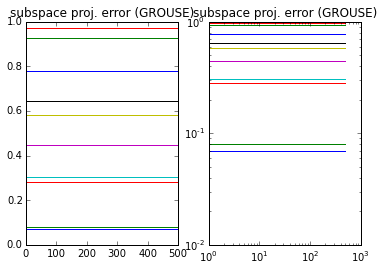

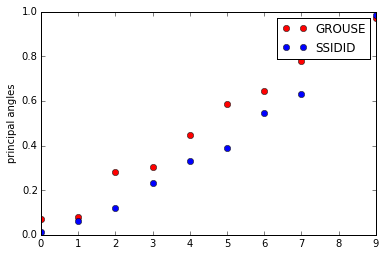

(p,n,k+l,T) =  (20, 10, 20, 520) 



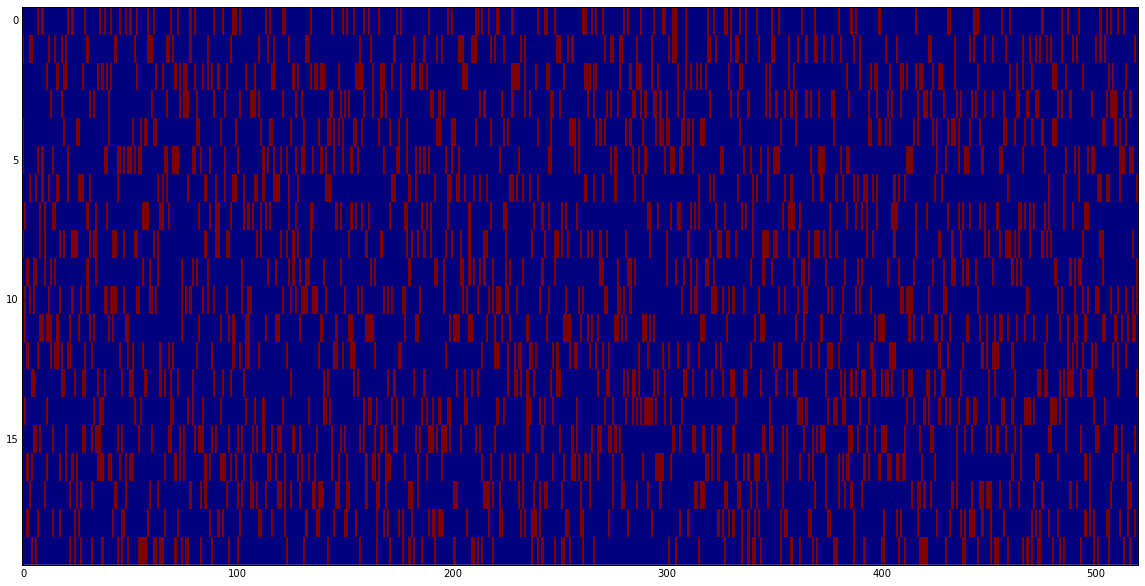

computing time-lagged covariances
true param. loss:  433.813312435
m = 0, corr = 0.851813499567
m = 1, corr = 0.592046222019
m = 2, corr = 0.641908136024
m = 3, corr = 0.64413152673
m = 4, corr = 0.575411834289
m = 5, corr = 0.575353059862
m = 6, corr = 0.527668673177
m = 7, corr = 0.543264662806
m = 8, corr = 0.548064334768
m = 9, corr = 0.550082927848
m = 10, corr = 0.449750032532
m = 11, corr = 0.522545361968
m = 12, corr = 0.494097639915
m = 13, corr = 0.376586237973
m = 14, corr = 0.428050377331
m = 15, corr = 0.354250766734
m = 16, corr = 0.453929543198
m = 17, corr = 0.406129348755
m = 18, corr = 0.406080824565
m = 19, corr = 0.339936032919
parametrization: nl
starting descent
finished % 10.0
f =  919.062496848
finished % 20.0
f =  527.82012057
finished % 30.0
f =  489.914685058
finished % 40.0
f =  467.186991845
finished % 50.0
f =  433.744416753
finished % 60.0
f =  429.253214987
finished % 70.0
f =  426.370306123
finished % 80.0
f =  405.215997003
finished % 90.0
f =  401.313

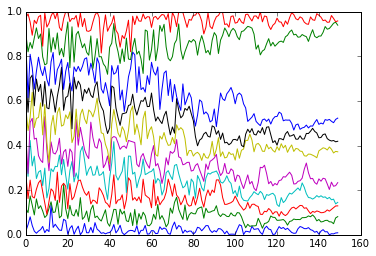

parametrization: nl
starting descent
finished % 10.0
f =  394.658254799
finished % 20.0
f =  372.960049197
finished % 30.0
f =  371.151432798
finished % 40.0
f =  363.3983921
finished % 50.0
f =  357.984880016
finished % 60.0
f =  359.080855396
finished % 70.0
f =  355.775821349
finished % 80.0
f =  354.797325523
finished % 90.0
f =  353.715675516
finished % 100.0
f =  352.893419949
total iterations:  12500
m = 0, corr = 0.695525726324
m = 1, corr = 0.745453916125
m = 2, corr = 0.729467712038
m = 3, corr = 0.732119565406
m = 4, corr = 0.736164407344
m = 5, corr = 0.66965965235
m = 6, corr = 0.714435176791
m = 7, corr = 0.727260926864
m = 8, corr = 0.729514596941
m = 9, corr = 0.755487060938
m = 10, corr = 0.695993000316
m = 11, corr = 0.691706444775
m = 12, corr = 0.698595326557
m = 13, corr = 0.709825019128
m = 14, corr = 0.653494830437
m = 15, corr = 0.717077705043
m = 16, corr = 0.668604598067
m = 17, corr = 0.656764816487
m = 18, corr = 0.665785220477
m = 19, corr = 0.627376776191


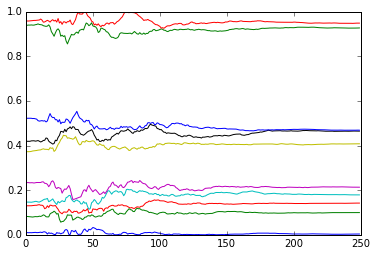

parametrization: ln
starting descent
finished % 10.0
f =  617.489263193
finished % 20.0
f =  450.239047594
finished % 30.0
f =  430.031646458
finished % 40.0
f =  419.095188789
finished % 50.0
f =  418.808062957
finished % 60.0
f =  417.216761163
finished % 70.0
f =  416.394682698
finished % 80.0
f =  416.279717482
finished % 90.0
f =  413.291471527
finished % 100.0
f =  414.965837752
total iterations:  12500
m = 0, corr = 0.674952096694
m = 1, corr = 0.661162945502
m = 2, corr = 0.619832599926
m = 3, corr = 0.624801255544
m = 4, corr = 0.628949586195
m = 5, corr = 0.575411521826
m = 6, corr = 0.615118399756
m = 7, corr = 0.623758527367
m = 8, corr = 0.578511068806
m = 9, corr = 0.592686532451
m = 10, corr = 0.573791032093
m = 11, corr = 0.49861361902
m = 12, corr = 0.55031654894
m = 13, corr = 0.535549446161
m = 14, corr = 0.51039604326
m = 15, corr = 0.510674811881
m = 16, corr = 0.476865360891
m = 17, corr = 0.483582099082
m = 18, corr = 0.482390921404
m = 19, corr = 0.439854170818


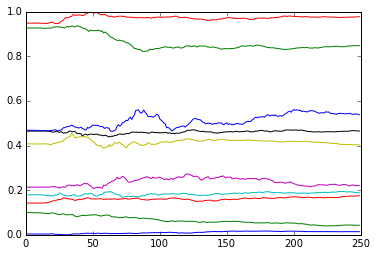

parametrization: ln
starting descent
finished % 10.0
f =  413.039714017
finished % 20.0
f =  413.061298722
finished % 30.0
f =  412.99761091
finished % 40.0
f =  412.958010266
finished % 50.0
f =  412.976857154
finished % 60.0
f =  412.952226051
finished % 70.0
f =  412.805356229
finished % 80.0
f =  412.737616839
finished % 90.0
f =  412.699169796
finished % 100.0
f =  412.673041905
total iterations:  1000
m = 0, corr = 0.674474552798
m = 1, corr = 0.661721527078
m = 2, corr = 0.620866780612
m = 3, corr = 0.625577827919
m = 4, corr = 0.629894748018
m = 5, corr = 0.577225500577
m = 6, corr = 0.615437196513
m = 7, corr = 0.624364643082
m = 8, corr = 0.5798015526
m = 9, corr = 0.593250556411
m = 10, corr = 0.574523633828
m = 11, corr = 0.500509536789
m = 12, corr = 0.55082665972
m = 13, corr = 0.535623724714
m = 14, corr = 0.510933250119
m = 15, corr = 0.511296968798
m = 16, corr = 0.477573965529
m = 17, corr = 0.484346178321
m = 18, corr = 0.483452405492
m = 19, corr = 0.4405117793
fitt

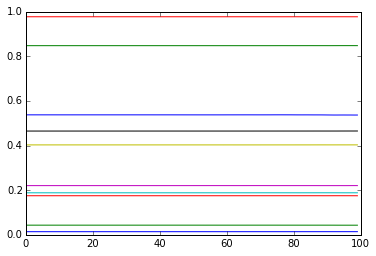


 - GROUSE
finished % 0
finished % 10
finished % 20
finished % 30
finished % 40
finished % 50
finished % 60
finished % 70
finished % 80
finished % 90
final proj. error (est.):  0.713381308369


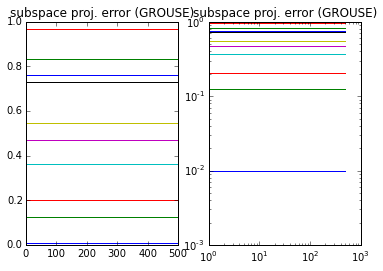

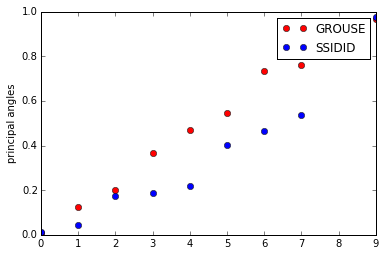





seed: 31






FileNotFoundError: [Errno 2] No such file or directory: '/home/mackelab/Desktop/Projects/Stitching/results/icml_e3/rnd/seed_31/y'

In [1]:
% matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import glob, os, psutil, time
from scipy import linalg as la
from ssidid.SSID_Hankel_loss import run_bad, plot_slim, print_slim, f_l2_Hankel_nl, f_l2_Hankel_comp_Q_Om
from ssidid.utility import get_subpop_stats, gen_data
from ssidid import ObservationScheme
from subtracking import Grouse, calc_subspace_proj_error
from ssidid.icml_scripts import run_default

run = '_e3rnd'

# define problem size
lag_range = np.arange(20)
kl_ = np.max(lag_range)+1
p, n = 20, 10
T_full = 500 + kl_
T = T_full

nr = 0 # number of real eigenvalues
snr = (1., 1.)
whiten = True
eig_m_r, eig_M_r, eig_m_c, eig_M_c = 0.90, 0.99, 0.90, 0.99

def principal_angle(A, B):
    "A and B must be column-orthogonal."    
    A = np.atleast_2d(A).T if (A.ndim<2) else A
    B = np.atleast_2d(B).T if (B.ndim<2) else B
    A = la.orth(A)
    B = la.orth(B)
    svd = la.svd(A.T.dot(B))
    return np.arccos(np.minimum(svd[1], 1.0)) / (np.pi/2)


# I/O matter
mmap, chunksize = True, np.min((p,1000))
verbose=True


sso = True
frac_obs = 0.2

obs_scheme = ObservationScheme(p=p, T=T, 
                                sub_pops=(np.arange(p),), 
                                obs_pops=(0,), 
                                obs_time=(T,))


rnd_seeds = range(30,40)
fracs_obs = (0.1, 0.2)
#fracs_obs = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0)


for rnd_seed in rnd_seeds:
    
    data_path =  '/home/mackelab/Desktop/Projects/Stitching/results/icml_e3/rnd/seed_' + str(rnd_seed) + '/'

    print('\n')
    print('\n')
    print('seed:', str(rnd_seed))
    print('\n')
    print('\n')
    
    np.random.seed(rnd_seed)
    pars_true, x, y, _, _ = gen_data(p,n,lag_range,T, nr,
                                     eig_m_r, eig_M_r, 
                                     eig_m_c, eig_M_c,
                                     mmap, chunksize,
                                     data_path,
                                     snr=snr, whiten=whiten)        
    y = np.memmap(data_path+'y', dtype=np.float, mode='r+', shape=(T,p))
    y -= y.mean(axis=0)
    #y[np.invert(obs_scheme.mask)] = np.nan
    del y
    y = np.memmap(data_path+'y', dtype=np.float, mode='r', shape=(T,p))
    idx_a, idx_b = np.arange(p), np.arange(p)
    
    
    for frac_obs in fracs_obs:

        n_obs = np.ceil(p * frac_obs)
        mask = np.zeros((T,p),dtype=bool)
        for t in range(T):
            mask[t, np.random.choice(p, n_obs, replace=False)] = 1
        obs_scheme.mask = mask

        print('(p,n,k+l,T) = ', (p,n,len(lag_range),T), '\n')

        if p*T < 1e8:
            plt.figure(figsize=(20,10))
            plt.imshow(obs_scheme.mask.T, interpolation='None', aspect='auto')
            plt.grid('off')
            plt.show()

        W = [ 1 / (frac_obs**2 * T * np.ones((1,1))) for m in range(len(lag_range))]

        print('computing time-lagged covariances')
        #Om = [np.ones((p,p), dtype=bool) for m in lag_range]
        #Qs = [np.zeros((p,p)) for m in lag_range]
        Qs, Om = f_l2_Hankel_comp_Q_Om(n=n,y=y,lag_range=lag_range,obs_scheme=obs_scheme,
                              idx_a=idx_a,idx_b=idx_b,W=W,sso=False,
                              mmap=mmap,data_path=data_path,ts=None,ms=None)
        
        pars_true['X'] = np.vstack([ np.linalg.matrix_power(pars_true['A'],m).dot(pars_true['Pi']) for m in lag_range])
        print('true param. loss: ', f_l2_Hankel_nl(C=pars_true['C'],X=pars_true['X'],R=pars_true['R'],
                                       Qs=Qs,Om=Om,lag_range=lag_range,ms=range(len(lag_range)),idx_a=idx_a,idx_b=idx_b))        
        print_slim(Qs,Om,lag_range,pars_true,idx_a,idx_b,_,False,data_path)


        pars_est, traces, ts = run_default(
                    alphas    = (0.01, 0.005, 0.001, 0.0001), 
                    b1s       = (0.98, 0.95,  0.95,  0.9), 
                    a_decays  = (0.98, 0.98,  0.99,  0.99), 
                    batch_sizes = (1, 10,    10,    50), 
                    max_zip_sizes =  (1000,100,100, 50), 
                    max_iters = (150, 250, 250, 100),
                    parametrizations = ('nl', 'nl', 'ln', 'ln'),
                    pars_est='default', pars_true=pars_true, n=n, 
                    y=y, sso=True, obs_scheme=obs_scheme, lag_range=lag_range, 
                    idx_a=idx_a, idx_b=idx_b,Qs=Qs,Om=Om, W=W,
                    traces=[[], [], []], ts = [])    
        
        # settings for GROUSE
        a_grouse = 10
        tracker = Grouse(p, n, a_grouse )
        max_epoch_size = 1000
        max_iter_grouse = 500
        get_obs = obs_scheme.gen_get_observed()

        # fit GROUSE
        print('\n - GROUSE')
        tracker.step = a_grouse
        ct = 1.
        error = np.zeros((max_iter_grouse, n+1))
        t = time.time()

        for i in range(max_iter_grouse):
            if verbose and np.mod(i,max_iter_grouse//10) == 0:
                print('finished % ' + str((100*i)//max_iter_grouse))
            idx = np.random.permutation(T-np.max(lag_range)-1)
            idx = idx[:max_epoch_size] if len(idx) > max_epoch_size else idx
            for j in range(len(idx)):
                tracker.consume(y[idx[j],:].reshape(-1,1), obs_scheme.mask[idx[j],:].reshape(-1,1))
                ct += 1     
                tracker.step = a_grouse / ct

            error[i] = np.hstack((calc_subspace_proj_error(pars_true['C'], tracker.U), principal_angle(pars_true['C'], tracker.U)))

        t = time.time() - t

        pars_est_g = {'C' : tracker.U.copy()}
        traces_g = [error.copy()]
        ts_g = [t]

        save_dict = {'p' : p,'n' : n,'T' : T,'snr' : snr,'lag_range' : lag_range,
                     'obs_scheme' : obs_scheme, 'mmap' : mmap,'y' : data_path if mmap else y,
                     'pars_true' : pars_true, 'pars_est' : pars_est, 'pars_est_g' : pars_est_g,
                     'idx_a' : idx_a,'idx_b' : idx_b, 'W' : W,'Qs' : Qs,'Om' : Om,
                     'traces' : traces, 'traces_g' : traces_g, 'ts':ts, 'ts_g':ts_g,
                     'rnd_seed' : rnd_seed
                    }
        file_name = 'p'+str(p)+'n'+str(n)+'T'+str(T)+str(run)+'_'+str(100*frac_obs)
        np.savez(data_path + file_name, save_dict)    

        print('final proj. error (est.): ', str(error[-1][0]))

        plt.subplot(1,2,1)
        plt.plot(error[:,1:])
        plt.title('subspace proj. error (GROUSE)')

        plt.subplot(1,2,2)
        plt.loglog(error[:,1:])
        plt.title('subspace proj. error (GROUSE)')
        plt.show()
        
        plt.plot(principal_angle(pars_true['C'], tracker.U), 'ro')
        plt.plot(principal_angle(pars_true['C'], pars_est['C']), 'bo')
        plt.legend(('GROUSE', 'SSIDID'))
        plt.ylabel('principal angles')
        plt.show()


In [ ]:
Q_est = pars_est['C'].dot(pars_est['X'][:n,:]).dot(pars_est['C'].T) + np.diag(pars_est['R'])

plt.figure(figsize=(20,6))
plt.imshow(np.hstack((Qs[0], np.cov(y.T), Q_est)), interpolation='None')
plt.show()

plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(Qs[0].reshape(-1), np.cov(y.T).reshape(-1), 'b.')
plt.axis([-0.5, 2.5, -0.5, 2.5])

plt.subplot(1,3,2)
plt.plot(Q_est.reshape(-1), np.cov(y.T).reshape(-1), 'b.')
plt.axis([-0.5, 2.5, -0.5, 2.5])

plt.subplot(1,3,3)
plt.plot(Q_est.reshape(-1), Qs[0].reshape(-1), 'b.')
plt.axis([-0.5, 2.5, -0.5, 2.5])

plt.show()

W = obs_scheme.comp_coocurrence_weights(lag_range, sso=False, idx_a=idx_a, idx_b=idx_b)

for m in range(len(lag_range)):
    plt.imshow(1/W[m], interpolation='None')
    plt.colorbar()
    plt.show()